# BERT experiment

In this experiment we run the BERT model on the real world dataset as described in Section 2.6 of the paper and report the scores for both ELM and BCUBED and make various plots to show the differences between the two metrics. In this part of the research we want to show that, when comparing the scors of a model that is already really good on the task, the difference between the F1 scors of the two metrics is still relatively large.

## Index

1. [Data Loading](#ref1)
2. [BERT Model scores](#ref2)

<a id="ref1" />

## Loading in the data

We again start by loading in the data, but for this experiment we only load in the test data, as we have trained the BERT model on the trainset, and thus cannot use it for testing, something that was not a problem for the non-learned baselines.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

# Import the plotting function we had from the BaselineExperiments file.
%run ../utils/metricutils.py


def read_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

As opposed to the previous experiments, the predictions of the model have been saved beforehand and are included in the data, to save the time it would take to run the predictions of the model, which can take quite a bit of time on a CPU. For the sake of reproducibility, we have included the original code of the BERT model for training and testing, so that someone who wants can train and test the model from scratch.

In [2]:
# Load in the predictions and gold standard from json files.
bert_predictions = {key: np.array(val) for key, val in read_json('BERT_model_predictions.json').items()}
gold_standard = {key: np.array(val) for key , val in read_json('../data/test/test.json').items()}

In [3]:
# Print the statistics of the testset dataset
gold_standard_lengths = pd.Series([len(bin_to_length_list(np.array(item))) for item in gold_standard.values()])
print("Distribution of the number of cluster per stream")
display(gold_standard_lengths.describe().astype(int))

Distribution of the number of cluster per stream


count     34
mean     186
std      220
min        1
25%       24
50%       57
75%      324
max      736
dtype: int64

<a id="ref2" />

## BERT Model scores

We use the functions we have defined in the previous notebook from the baselines experiments here to calculate the scores for the BERT based model.

In [4]:
BERT_model_bcubed_all_elements, BERT_model_elm_all_elements = get_bcubed_and_elm_scores(gold_standard, bert_predictions)

In [5]:
BERT_model_bcubed_stream_scores, BERT_model_elm_stream_scores = get_mean_stream_predictions(BERT_model_bcubed_all_elements), get_mean_stream_predictions(BERT_model_elm_all_elements)

In [6]:
create_score_dataframe(BERT_model_bcubed_stream_scores, BERT_model_elm_stream_scores)

,P,R,F1
BCUBED,"$\mu=$0.93, $\sigma$=0.07","$\mu=$0.85, $\sigma$=0.26","$\mu=$0.83, $\sigma$=0.24"
ELM,"$\mu=$0.92, $\sigma$=0.08","$\mu=$0.85, $\sigma$=0.26","$\mu=$0.8, $\sigma$=0.24"


What is interesting to see in the above table is that although the scores for both the Precision and Recall of ELM and BCUBED are very close together, the overall difference in the F1 score quite large. This is interesting, as a lot of papers will indicate their model scores using this F1 score, and thus this again highlights the importance of having a score that is consistent, even when the distribution of elements might be different. 

In [7]:
# For examining the confidence intervals
evaluation_report(gold_standard, bert_predictions, title="the BERT PSS model on the test set (N=34)")

<b> Mean scores of the evaluation metrics for the BERT PSS model on the test set (N=34) </b>

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Bcubed,0.93,0.85,0.83,6347,0.92-0.94,0.84-0.86,0.82-0.84
ELM,0.92,0.85,0.80,6347,0.91-0.93,0.84-0.86,0.79-0.81


### KDE plots for the BERT Model

As with the baseline models from the baselines notebook, we are going to plot two KDE plots for the BERT model: One where we make a kde over the scores of all elements, and one where we make a KDE over the scores over the aggregated values, i.e. the means over elements in each stream.

In [8]:
def bin_bcubed_kde_differences(bcubed_dataframe, elm_dataframe):
    differences = bcubed_dataframe[['P', 'R', 'F1']] - elm_dataframe[['P', 'R', 'F1']]
    f1_differences = differences['F1']
    difference_bins = (0.0, 0.1, 0.2, 0.5, 0.75, 1.0)
    binned_values = pd.cut(f1_differences, right=False, bins=difference_bins, labels=['0', '0.1 < 0.2', '0.2 < 0.5',
                                                                     '0.5 < 0.75', '0.75 < 1.0'])
    
    diff_df = pd.DataFrame({'F1': f1_differences, 'bin': binned_values})

    difference_table = diff_df['bin'].value_counts()
    
    display(difference_table.sort_index())



#### KDE plot over all elements

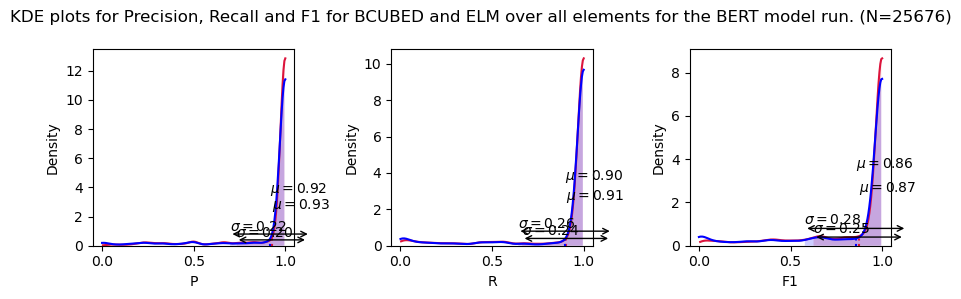

In [9]:
plot_p_r_f1_difference_kdes(BERT_model_bcubed_all_elements[['P', 'R', 'F1']], BERT_model_elm_all_elements[['P', 'R', 'F1']])
plt.suptitle("KDE plots for Precision, Recall and F1 for BCUBED and ELM over all elements for the BERT model run. (N=25676)")
plt.tight_layout()
plt.show()

In [10]:
# More difference than with the giant cluster predictions, but the differences in general are still pretty
# small.
bin_bcubed_kde_differences(BERT_model_bcubed_all_elements, BERT_model_elm_all_elements)

0             24430
0.1 < 0.2       861
0.2 < 0.5       161
0.5 < 0.75      224
0.75 < 1.0        0
Name: bin, dtype: int64

#### KDE plot over streams

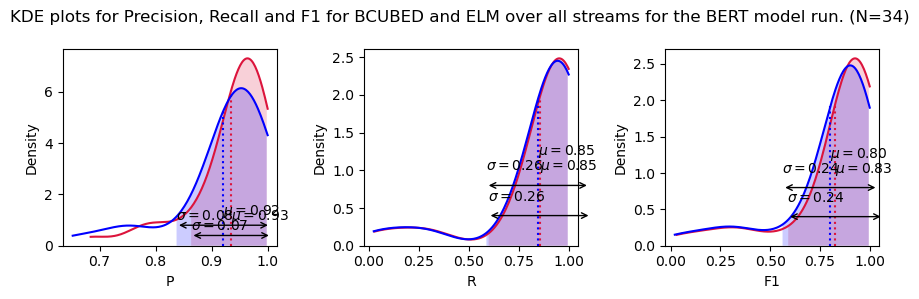

In [11]:
plot_p_r_f1_difference_kdes(BERT_model_bcubed_stream_scores[['P', 'R', 'F1']], BERT_model_elm_stream_scores[['P', 'R', 'F1']],
                           mean_label_locations=[1, 1.2])
plt.suptitle("KDE plots for Precision, Recall and F1 for BCUBED and ELM over all streams for the BERT model run. (N=34)")
plt.tight_layout()
plt.show()

What we can see from the above plots is that the difference between the two metrics is actually more noticeable when we plot it as the aggregated stream values, and that when we plot the KDE over all elements the metrics seem to be way closer together.

## Recreation of Figure 5

For this part of the notebook we are going to recreate the original Figure 5 from the ICTIR paper, were we take the differences between the two metrics and plot the KDEs of them in one Figure. Like with the previous KDE plots, we will do this both for the raw scores of all the elements, as well as the aggregated scores of the streams.

In [12]:
metric_differences_all_elements = BERT_model_bcubed_all_elements[['P', 'R', 'F1']] - BERT_model_elm_all_elements[['P', 'R', 'F1']]
metric_differences_stream = BERT_model_bcubed_stream_scores[['P', 'R', 'F1']] - BERT_model_elm_stream_scores[['P', 'R', 'F1']]

In [13]:
# Now create the function that will add some interesting information to the plot
def plot_kde_with_info(column_data, color, text_label,i, label_y_pos=0.5, std_y_loc: float=15.0, std_label_pos: float = 15,
                      linestyle: str=None):
    kde_plot = sns.kdeplot(data=column_data, cut=0, clip=[0, 1], label=text_label,
                             shade=False, color=color, ls=linestyle)
    lines_x = kde_plot.lines[i].get_xdata()
    lines_y = kde_plot.lines[i].get_ydata()
    lines_mean = column_data.mean()
    lines_std = column_data.std()

    height = np.interp(lines_mean, lines_x, lines_y)
    kde_plot.vlines(lines_mean, 0, height, color=color, ls=':')
    
    plt.annotate("", (lines_mean - lines_std, std_y_loc), (lines_mean+lines_std, std_y_loc), arrowprops=dict(arrowstyle='<->'))
    std_label = plt.text(max(0.001, lines_mean-lines_std), std_label_pos, s="$\sigma=%.2f$" % lines_std, fontsize=10)
    # Create labels for the actual values of the mean and standard deviation of the KDE plot
    # axis.text(max(0.1, data_mean-data_std), std_label_location, s="$\sigma=%.2f$" % data_std, fontsize=fontsize)

    
    
    # Standard deviation vertical lines.
    
    mean_label = plt.text(lines_mean, label_y_pos, s="$\mu=%.2f$" % lines_mean, fontsize=10)


### Difference Plot over all elements

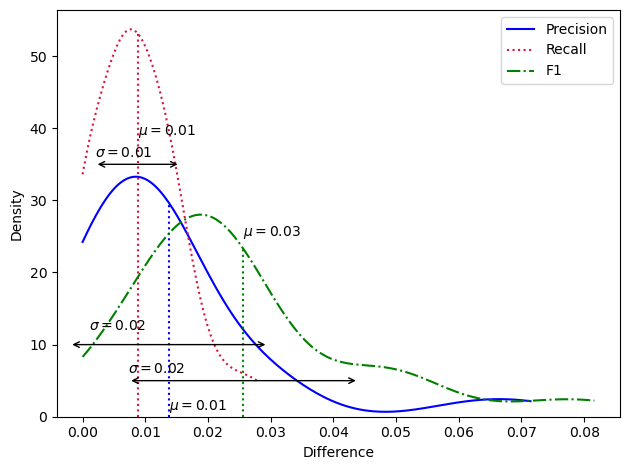

In [14]:
plot_kde_with_info(metric_differences_stream['P'], color='blue', text_label="Precision",i=0, label_y_pos=1, std_y_loc=10, std_label_pos=12, linestyle='-')
plot_kde_with_info(metric_differences_stream['R'], color='crimson', text_label="Recall",i=1, label_y_pos=39, std_y_loc=35, std_label_pos=36, linestyle=':')
plot_kde_with_info(metric_differences_stream['F1'], color='green', text_label="F1",i=2, label_y_pos=25, std_y_loc=5, std_label_pos=6, linestyle='-.')
plt.xlabel("Difference")
# plt.ylabel("")
# plt.yticks([])
plt.legend()
plt.tight_layout()
plt.savefig("../images/Fig5.png")
plt.show()